# Pretraining Faizan's LLM

In [22]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.2
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.2.1+cu121


In [72]:


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()


def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [24]:
import torch



GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [25]:



def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [26]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


<br>





# Preparing the dataset loaders

In [27]:
with open("FaizansLLM/04_pretraining/the-verdict.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

- A quick check that the text loaded ok by printing the first and last 100 words

In [28]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [29]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [30]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [31]:



# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [32]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [33]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [34]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583372328016
Validation loss: 10.98110580444336






##  Training Faizan's LLM

In [35]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01

In [36]:
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

27


In [37]:
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
    
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr
        
        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

In [39]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []

lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
    
        # Adjust the learning rate based on the current phase (warmup or cosine annealing)
        if global_step < warmup_steps:
            # Linear warmup
            lr = initial_lr + global_step * lr_increment  
        else:
            # Cosine annealing after warmup
            progress = ((global_step - warmup_steps) / 
                        (total_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                1 + math.cos(math.pi * progress))
        
        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])
    

In [40]:
from LLMcore import calc_loss_batch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [41]:
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print(find_highest_gradient(model))

tensor(0.0839)


In [46]:
Clipping_Flag = False


def train_model_simple(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):

    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    # Retrieve the maximum learning rate from the optimizer
    peak_lr = optimizer.param_groups[0]["lr"]

    # Calculate the total number of iterations in the training process
    total_training_steps = len(train_loader) * n_epochs

    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            # Adjust the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < warmup_steps:
                # Linear warmup
                lr = initial_lr + global_step * lr_increment  
            else:
                # Cosine annealing after warmup
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # Apply the calculated learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Store the current learning rate

            # Calculate and backpropagate the loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            # Apply gradient clipping after the warmup phase to avoid exploding gradients
            if Clipping_Flag:
                if global_step > warmup_steps:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
            else:
                if global_step >= warmup_steps:  # the book originally used global_step > warmup_steps, which lead to a skipped clipping step after warmup
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
            optimizer.step()
            tokens_seen += input_batch.numel()

            # Periodically evaluate the model on the training and validation sets
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # Print the current losses
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        # Generate and print a sample from the model to monitor progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen, track_lrs

I train the LLM using the training function defined above:

In [53]:
import tiktoken

# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001  # this was originally set to 5e-4 in the book by mistake
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)  # the book accidentally omitted the lr assignment
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Iter 000000): Train loss 10.924, Val loss 10.939
Ep 1 (Iter 000005): Train loss 9.317, Val loss 9.460
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.971, Val loss 8.179
Ep 2 (Iter 000015): Train loss 6.589, Val loss 6.852
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 5.996, Val loss 6.634
Ep 3 (Iter 000025): Train loss 6.045, Val loss 6.828
Every effort moves you. Gisburn. G. G. I had I had. I had I had I had I had I had I had I had I had I had I had I had. G I had I had I had I had I had I had
Ep 4 (Iter 000030): Train loss 6.398, Val loss 7.008
Ep 4 (Iter 000035): Train loss 5.966, Val loss 6.972
Every effort moves you                                                  
Ep 5 (Iter 000040): Train loss 6.082, Val loss 6.867
Every effort moves you, and, and the, and, and the, and the the., and the, and the the the, and the the, and the the the the the the the the the 

In [54]:
torch.save(model.state_dict(), "model.pth")

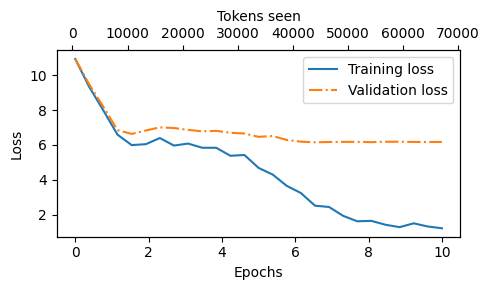

In [55]:



epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [56]:
model.eval();

Upon examining the results above, we observe a striking transformation in the model’s generative capabilities. Initially, it churns out a disjointed, unintelligible cascade of words, an erratic stream devoid of coherence. Yet, as training progresses, it begins to construct sentences that, while not flawless, adhere to grammatical conventions with increasing precision.

However, a closer analysis of the training and validation losses unveils an inevitable pitfall—overfitting. The model, instead of generalizing language patterns, begins to memorize its training data. If one were to scrutinize its later passages, one would discover entire segments lifted verbatim from the dataset, betraying a reliance on rote recall rather than true linguistic synthesis.

There exist decoding strategies—beyond the scope of this workshop—that can temper this tendency to overfit, fostering a more creative and original output. But it is also worth noting that the overfitting we observe here stems largely from the brevity of our training corpus and the relentless cycling through it.

Ultimately, this exercise is not about sculpting a state-of-the-art language model; rather, it is a pedagogical endeavor—a window into how an LLM gradually learns to weave meaningful text from raw data. Were we pursuing a production-grade model, the process would span weeks, even months, consuming vast computational resources. Instead, for the sake of efficiency, we later load pretrained weights, allowing us to bypass this Herculean effort and focus on the mechanics of fine-tuning.



In [57]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(model=model, idx=text_to_token_ids("Every effort moves you", tokenizer), max_new_tokens=25, context_size=GPT_CONFIG_124M['context_length'])

print("Output text :\n", token_ids_to_text(token_ids, tokenizer))

Output text :
 Every effort moves you know," was one of the axioms he had been the frame.
"I was no great, one of Jack


**Temprature scaling**

In [58]:
# to illustrate 
vocab = {
    "closer" : 0,
    "every" : 1,
    "effort" : 2,
    "forward" : 3,
    "inches" : 4,
    "movesr" : 5,
    "pizza" : 6,
    "toward" : 7,
    "you" : 8,
}

inverese_vocab = {v : k for k , v in vocab.items()}

In [59]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

In [60]:
probas = torch.softmax(next_token_logits, dim=0)
# next_token_id = torch.argmax(probas).item()
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverese_vocab[next_token_id])

forward


In [61]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i , freq in enumerate(sampled_ids):
        print(f"{freq} x {inverese_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x movesr
0 x pizza
376 x toward
4 x you


In [62]:
# temprature scaling 
def softmax_with_temprature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

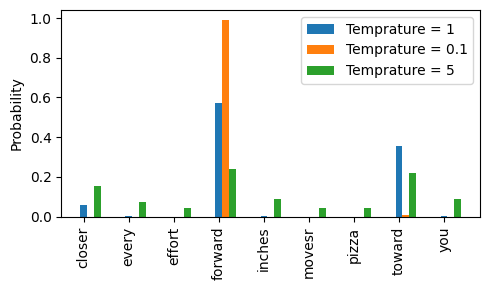

In [63]:
import matplotlib.pyplot as plt

temperature = [1 , 0.1 , 5]
scaled_probas = [softmax_with_temprature(next_token_logits, T) for T in temperature]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i , T in enumerate(temperature):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temprature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [64]:
# exc 5.1
scaled_probas = softmax_with_temprature(next_token_logits, 5)

def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i , freq in enumerate(sampled_ids):
        print(f"{freq/10:.1f}% x {inverese_vocab[i]}")

print_sampled_tokens(scaled_probas)

15.3% x closer
6.8% x every
5.5% x effort
22.3% x forward
10.2% x inches
5.0% x movesr
4.3% x pizza
21.8% x toward
8.8% x you


### Top-K sampling

In [65]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("all logits : ", next_token_logits)
print("top logits : ", top_logits)
print("top postions : ", top_pos)

all logits :  tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])
top logits :  tensor([6.7500, 6.2800, 4.5100])
top postions :  tensor([3, 7, 0])


In [66]:
# setting exluding values to -inf 
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input = torch.tensor(float('-inf')),
    other = next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [67]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Altering the text generation function to incorporate Temperature scaling and Top- K 

In [68]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [69]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15, 
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=15,
    temperature=0.1
)

print("output text : ", token_ids_to_text(token_ids, tokenizer))

output text :  Every effort moves you know," was one of the axioms he had been the frame.


### Saving the model weights in PyTorch

In [70]:
torch.save(model.state_dict(), "model.pth")

In [71]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features